In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import acos, sin, cos, radians, atan
from ortools.constraint_solver import pywrapcp

### Load Data

In [2]:
# load dataframe
data = pd.read_csv('data-demo/hygdata_v3.csv').set_index('id') # read a CSV file
data = data[~data['proper'].isna()][['proper', 'dist', 'ra', 'dec', 'pmra', 'pmdec']].dropna()
data = data.reset_index()

# unit conversions
data['dist'] = data['dist'].apply(lambda x: x*3.262) # convert from parsecs to lightyears
data['ra'] = data['ra'].apply(lambda x: x*15) # convert from hours to degrees 
data['pmra'] = data['pmra'].apply(lambda x: x*2.7777776630942*10**(-7)) # convert to degrees per year
data['pmdec'] = data['pmdec'].apply(lambda x: x*2.7777776630942*10**(-7)) # convert to degrees per year

# rename fields
data = data.rename(columns={'ra' : 'ra_2000', 'dec' : 'dec_2000'})

# calcualte 2020 right ascension and declination
data['ra_2020'] = data['ra_2000'] + 20*data['pmra']
data['dec_2020'] = data['dec_2000'] + 20*data['pmdec']

data.head() # preview

,id,proper,dist,ra_2000,dec_2000,pmra,pmdec,ra_2020,dec_2020
0,0,Sol,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,676,Alpheratz,97.025580,2.096865,29.090432,0.000038,-0.000045,2.097619,29.089527
2,744,Caph,54.750060,2.293305,59.149780,0.000145,-0.000050,2.296213,59.148778
3,1065,Algenib,391.596576,3.308970,15.183596,0.000001,-0.000002,3.308996,15.183550
4,2076,Ankaa,84.727188,6.570840,-42.305981,0.000065,-0.000098,6.572133,-42.307946


### Create and Solve Model

In [3]:
# Create a distance matrix (great-circle distance on unit circle)

# parameters
alpha = 1 
beta = 0

# get normal vectors
theta = data['ra_2020'].apply(lambda x: radians(x)).to_dict()
phi = data['dec_2020'].apply(lambda x: radians(x+90)).to_dict()
dist = data['dist'].apply(lambda x: radians(x)).to_dict()
n = {}

for i in range(len(data)):
    x = cos(theta[i])*sin(phi[i])
    y = sin(theta[i])*sin(phi[i])
    z = cos(phi[i])
    n[i] = np.array([x,y,z])
    
d = np.zeros((len(data),len(data)))
for i in range(len(data)):
    for j in range(len(data)): 
        if i < j:
            rot_dist = atan(np.linalg.norm(np.cross(n[i],n[j]))/np.dot(n[i],n[j]))
            zoom_dist = abs(dist[i] - dist[j])
            total = alpha*rot_dist + beta*zoom_dist
            d[i,j] = total
            d[j,i] = total

In [4]:
# Create TSP model for OR-Tools

# number of locations, number of vehicles, start location
manager = pywrapcp.RoutingIndexManager(len(d), 1, 0)
routing = pywrapcp.RoutingModel(manager)

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return d[from_node, to_node]*1000

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

solution = routing.Solve()
tour = get_routes(solution, routing, manager)[0]

### Visualizations

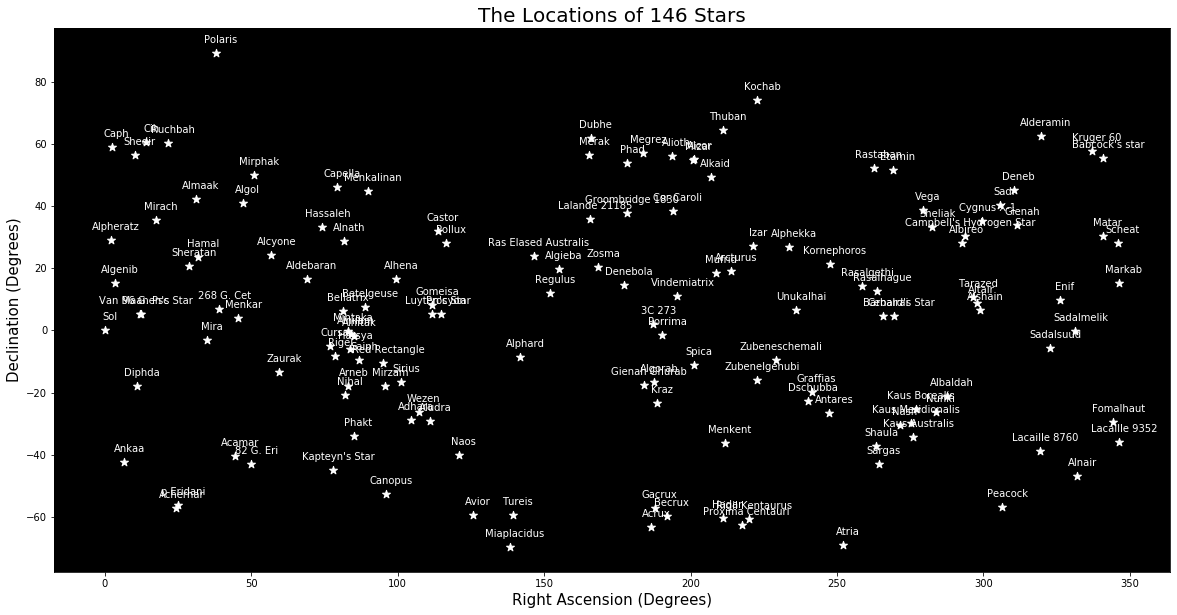

In [5]:
# generate a visualization of the star locations
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('black')
plt.scatter(data.ra_2020,data.dec_2020, marker='*', color='white', s=70)
for index, row in data.iterrows():
    plt.annotate(row['proper'], 
                 (row['ra_2020'],row['dec_2020']),
                 textcoords="offset points", 
                 xytext=(5,10),
                 color= 'white',
                 ha='center')
plt.title('The Locations of 146 Stars', fontsize= 20)
plt.xlabel('Right Ascension (Degrees)', fontsize= 15)
plt.ylabel('Declination (Degrees)', fontsize= 15)
plt.show()

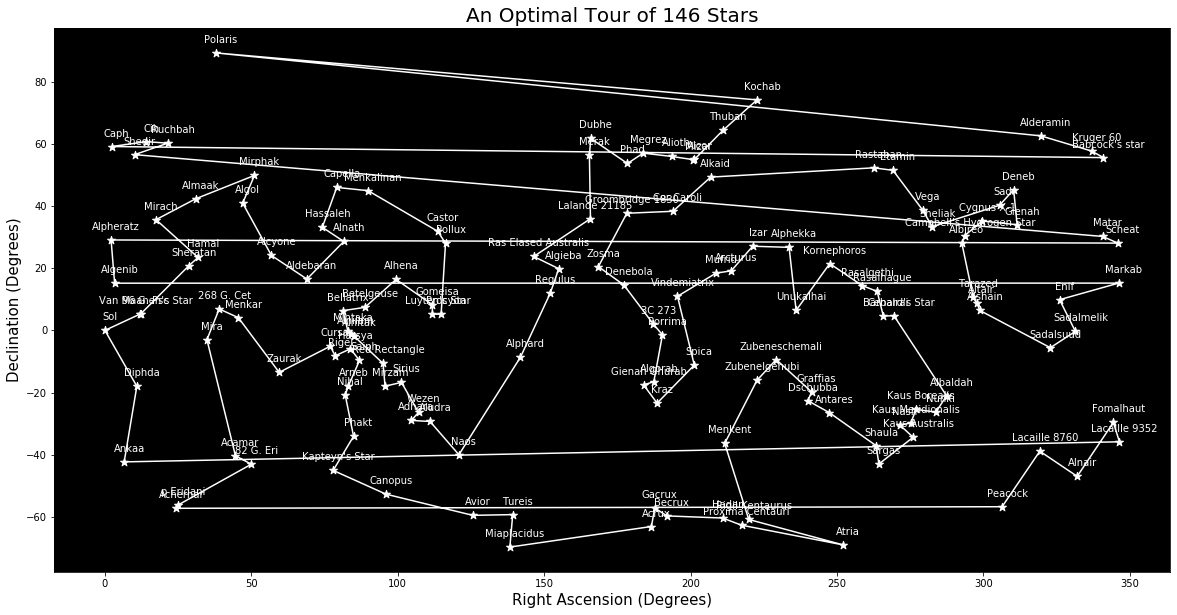

In [6]:
# Generate scatter plot of star locations
plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor('black')
plt.scatter(data.ra_2020,data.dec_2020, marker='*', color='white', s=70)
for index, row in data.iterrows():
    plt.annotate(row['proper'], 
                 (row['ra_2020'],row['dec_2020']),
                 textcoords="offset points", 
                 xytext=(5,10),
                 color= 'white',
                 ha='center')
    
# Add path through these stars
tour_proper = [data.iloc[i].proper for i in tour]
tour_proper.append(tour_proper[0])
tour_ra = [data[data.proper == proper].ra_2020.to_list()[0] for proper in tour_proper]
tour_dec = [data[data.proper == proper].dec_2020.to_list()[0] for proper in tour_proper]
plt.plot(tour_ra, tour_dec, color='white')

# Set axes titles and display
plt.title('An Optimal Tour of 146 Stars', fontsize= 20)
plt.xlabel('Right Ascension (Degrees)', fontsize= 15)
plt.ylabel('Declination (Degrees)', fontsize= 15)
plt.show()